In [1]:
import argparse
import os
import shutil
import sys
import time

import numpy as np
import torch
import torch.nn as nn
from sklearn import metrics
from torch.autograd import Variable
from torch.utils.data import DataLoader

import sys
sys.path.append('../')
from PTR_model_visu import Net
from PTR_data_1 import PeriodicTable, get_train_val_test_loader, collate_pool
from sklearn.utils import class_weight

modelpath='model_best.pth.tar'

In [2]:
dataset=PeriodicTable('flat_MP.csv')
collate_fn = collate_pool
test_loader = DataLoader(dataset, batch_size=1, shuffle=True,
                        num_workers=0, collate_fn=collate_fn,
                        pin_memory=False)

In [3]:
dataset

In [4]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """
    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


In [59]:
model=Net(classification=True)

In [60]:
model

Net(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1248, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [61]:
model_class=Net(classification=True)

In [62]:
normalizer = Normalizer(torch.zeros(2))
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)

In [63]:
model_class.load_state_dict(checkpoint['state_dict'])
normalizer.load_state_dict(checkpoint['normalizer'])

In [64]:
model_class

Net(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1248, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [51]:
model_class.conv1.parameters()

<generator object Module.parameters at 0x000002514177BB30>

In [11]:
params=[]
for param in model.fc1.parameters():
    params.append(param)

In [12]:
params_class=[]
for param in model_class.fc1.parameters():
    params_class.append(param)

In [65]:
pre_out=[]
compound=[]
target_var = []
wrong_ids = []
input_var=[]
for i, (inputs, target, ids)in enumerate(test_loader):
    input_var.append(inputs)

    try:
        pre_out.append(model_class(inputs))
        compound.append(ids)
        target_var.append(target)
    except ValueError:
        wrong_ids.append(ids)
        

In [77]:
target_var[0]

tensor([[0.]])

In [79]:
pre_out[0][1][6]

tensor([[ 2.2720, -2.2255]], grad_fn=<AddmmBackward0>)

In [96]:
pre_out[5][0].data.cpu()

tensor([[-4.6762, -0.0094]])

In [101]:
np.argmax(pre_out[5][0].data.cpu())

tensor(1)

In [45]:
compound.index(['Al1Cu2Mn1'])

750

In [53]:
input_var[750]

tensor([[[[-0.1000, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000],
          [-0.1000, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4000, -0.1000,
           -0.1000, -0.1000, -0.1000],
          [-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,  1.4000,
           -0.1000, -0.1000, -0.1000,  2.8000, -0.1000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000],
          [-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000],
          [-0.1000, -0.1000,  0.0000, -0.1000, -0.1000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
           -0.1000, -0.1000, -0.1000]]]])

In [52]:
pre_out[750][1][0][0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1472, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1691, 0.0000, 0.0000, 0.0000,
         0.5094, 0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0613, 0.0000, 0.0000,
         0.0000, 0.2987, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0278, 0.0000, 0.0000, 0.0000,
         0.2628, 0.0000, 0.0419, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward0>)

In [44]:
['Al1Cu2Mn1'] in compound

True

In [14]:
pt_pos={ 'Li': [0, 0], 'Be': [0, 1],  'B': [0, 12],  'C': [0, 13],  'N': [0, 14],  'O': [0, 15], 'F':[0, 16], 
                'Na': [1, 0], 'Mg': [1, 1], 'Al': [1, 12], 'Si': [1, 13],  'P': [1, 14],  'S': [1, 15], 'Cl':[1, 16],
                'K': [2, 0], 'Ca': [2, 1], 'Ga': [2, 12], 'Ge': [2, 13], 'As': [2, 14], 'Se': [2, 15], 'Br':[2,16],
                'Rb': [3, 0], 'Sr': [3, 1], 'In': [3, 12], 'Sn': [3, 13], 'Sb': [3, 14], 'Te': [3, 15], 'I': [3, 16],
                'Cs': [4, 0], 'Ba': [4, 1], 'Tl': [4, 12], 'Pb': [4, 13], 'Bi': [4, 14],
                'Sc': [2, 2], 'Ti': [2, 3],  'V': [2, 4], 'Cr': [2, 5], 'Mn': [2, 6], 'Fe': [2, 7], 'Co': [2, 8], 'Ni': [2, 9], 'Cu': [2, 10], 'Zn': [2, 11],
                'Y': [3, 2], 'Zr': [3, 3], 'Nb': [3, 4], 'Mo': [3, 5], 'Tc': [3, 6], 'Ru': [3, 7], 'Rh': [3, 8], 'Pd': [3, 9], 'Ag': [3, 10], 'Cd': [3, 11],
                'Hf': [4, 3], 'Ta': [4, 4],  'W': [4, 5], 'Re': [4, 6], 'Os': [4, 7], 'Ir': [4, 8], 'Pt': [4, 9], 'Au': [4, 10], 'Hg': [4, 11]}

In [15]:
def get_keys(d, value):
    return [k for k,v in d.items() if v == value]

In [39]:
for index in range(len(input_var)):
    ele=[]
    for i in range(len(input_var[index][0][0])):
        for j in range(len(input_var[index][0][0][i])):
            if input_var[index][0][0][i][j]==2.8:
                eleX=get_keys(pt_pos, [i,j])
                ele.append(eleX[0]+'2')
            elif input_var[index][0][0][i][j]==1.4:
                eleYZ=get_keys(pt_pos, [i,j])
                ele.append(eleYZ[0]+'1')
    print(ele)

['Si1', 'P2', 'Cd1']
['Ti1', 'V1', 'Tc2']
['Mo1', 'Ta2', 'Re1']
['Co2', 'Zn1', 'Nb1']
['Zr1', 'Tc2', 'Hf1']
['Be1', 'Fe1', 'Rh2']
['Tc1', 'Rh1', 'Hf2']
['Li1', 'Al1', 'Ag2']
['As1', 'Ba1', 'Hf2']
['Ti1', 'Zn1', 'Ir2']
['Li1', 'Pd2', 'In1']
['Be1', 'Rh2', 'Hf1']
['Cu1', 'Ga1', 'Pd2']
['Al1', 'Mn1', 'Ni2']
['Al1', 'Ti1', 'Mn2']
['K2', 'Sb1', 'Cs1']
['Li1', 'Pd1', 'Ag2']
['K1', 'Ti2', 'Bi1']
['Nb1', 'Tc2', 'Sn1']
['Ti1', 'Nb1', 'Re2']
['Cr1', 'Ga1', 'Ru2']
['Si1', 'P2', 'Zn1']
['Sr1', 'Hg2', 'Pb1']
['Ti1', 'Cu2', 'Sn1']
['Li1', 'Ge1', 'Ir2']
['K2', 'Rb1', 'Cs1']
['Cu1', 'Rh2', 'Sb1']
['Zn1', 'Zr1', 'Pd2']
['Be2', 'Ni1', 'Ir1']
['Si1', 'Fe1', 'Co2']
['K2', 'Cd1', 'Au1']
['Sr1', 'Ba1', 'Hg2']
['Ga1', 'Ru2', 'Ta1']
['Ru2', 'Hf1', 'Ta1']
['Al1', 'Fe2', 'Ta1']
['V1', 'Ga1', 'Ru2']
['Ni2', 'Ga1', 'Nb1']
['Mg2', 'Zn1', 'Pt1']
['Ni2', 'Nb1', 'Sn1']
['Ni2', 'Zr1', 'Sb1']
['Ti2', 'Ga1', 'Tc1']
['Mn1', 'Ta2', 'Os1']
['Si1', 'Mn1', 'Ni2']
['Rh1', 'Pd1', 'Cd2']
['Sr2', 'Sb1', 'Au1']
['Li2', 'Zn1', 'Sn

['Sr2', 'Pd1', 'Au1']
['Li2', 'Cd1', 'Hg1']
['Cr1', 'Nb2', 'Os1']
['Be1', 'Ga1', 'Rh2']
['Mg1', 'Pd2', 'Sb1']
['Al2', 'Rh1', 'Os1']
['Mn2', 'Rh1', 'Pt1']
['Ti1', 'Ni2', 'Sn1']
['V1', 'Ga1', 'Os2']
['Fe1', 'Ge1', 'Tc2']
['Ca2', 'As1', 'Au1']
['Ga2', 'Rh1', 'Ir1']
['Li1', 'Al1', 'Ni2']
['Be1', 'Si1', 'Rh2']
['Al1', 'V1', 'Mn2']
['O1', 'Nb1', 'Ba2']
['Zn1', 'Ba2', 'Tl1']
['Be1', 'Cl1', 'W2']
['Li2', 'Sn1', 'Tl1']
['Al1', 'Mn2', 'W1']
['Na1', 'In1', 'Hg2']
['Al1', 'Fe2', 'Nb1']
['Na2', 'Rb1', 'Sb1']
['Cr1', 'Sr1', 'Rh2']
['Nb2', 'Tc1', 'Os1']
['Nb1', 'Ta2', 'Re1']
['Ge1', 'Tc2', 'Ta1']
['Zn1', 'Nb1', 'Ru2']
['Mn1', 'Tc2', 'Sb1']
['Hf1', 'Ta1', 'Re2']
['Mo1', 'Ru1', 'Ta2']
['Ti2', 'Ni1', 'In1']
['Ti1', 'Ta1', 'Re2']
['Na1', 'Ca2', 'Rh1']
['Mn1', 'Ga1', 'Ru2']
['Zr2', 'Tc1', 'Ir1']
['Al1', 'Nb1', 'Os2']
['Li2', 'Sr1', 'Pb1']
['Li2', 'Cd1', 'Sb1']
['Li1', 'Ge1', 'Rh2']
['Co1', 'As2', 'Tl1']
['Ti1', 'Rh2', 'In1']
['Si1', 'Mn1', 'Co2']
['Li1', 'In1', 'Pt2']
['Sr2', 'In1', 'Hg1']
['Ti1', 'Fe2', 

['Al1', 'Cr1', 'Ru2']
['Ge1', 'Nb1', 'Ru2']
['Si1', 'V1', 'Os2']
['Cr1', 'Fe2', 'Sb1']
['Pd2', 'Ag1', 'Cd1']
['Ti2', 'Mn1', 'Tc1']
['Al1', 'Pd2', 'Hf1']
['Ti2', 'Tc1', 'Rh1']
['Si1', 'Mn1', 'Rh2']
['Ti2', 'Mn1', 'Fe1']
['Cu2', 'Zr1', 'In1']
['Mn1', 'Ni2', 'Ga1']
['Rh1', 'Hf2', 'Re1']
['B1', 'Ge1', 'In2']
['V1', 'Cu1', 'Rh2']
['Cu1', 'Zn2', 'Ir1']
['V1', 'Ru1', 'Ta2']
['Tc1', 'Hf2', 'Os1']
['Cr1', 'Sr1', 'W2']
['V1', 'Ni2', 'Ga1']
['Ni2', 'Ga1', 'Ta1']
['Mn1', 'Hf2', 'Os1']
['V1', 'Ga1', 'Tc2']
['Si1', 'Fe1', 'Tc2']
['Al1', 'V1', 'Fe2']
['Li2', 'Ca1', 'Ge1']
['Zr1', 'Nb1', 'Tc2']
['Ca2', 'Ge1', 'Hg1']
['Ca1', 'Cd1', 'Tl2']
['Ti2', 'Co1', 'Ir1']
['Zr1', 'Ru2', 'Hf1']
['Ti2', 'Tc1', 'Pd1']
['Si1', 'Cr1', 'Ru2']
['Co2', 'Zn1', 'Ga1']
['Al1', 'Fe1', 'Ir2']
['Fe1', 'Ru2', 'Sn1']
['Ti1', 'W1', 'Re2']
['Cu1', 'Zn1', 'Pd2']
['Mg1', 'Zr1', 'Au2']
['Ti2', 'Mn1', 'Ir1']
['V1', 'Mn2', 'In1']
['Al1', 'Ge1', 'Ru2']
['Be1', 'Si1', 'Ir2']
['Pd1', 'Ag1', 'Au2']
['Mg1', 'Al1', 'Ag2']
['Al1', 'Ni2', 'Ta1'

['Rb2', 'Cs1', 'Bi1']
['Mg2', 'Pd1', 'Au1']
['Be1', 'Hf1', 'Ir2']
['V2', 'Tc1', 'Ru1']
['Al1', 'Co2', 'Ta1']
['Be1', 'V1', 'Os2']
['Ca2', 'Cd1', 'Hg1']
['Si1', 'Nb1', 'Tc2']
['Mg1', 'Ga1', 'Ag2']
['Al2', 'Fe1', 'Rh1']
['Li1', 'Mg2', 'Rh1']
['Al1', 'Mn1', 'Pd2']
['Cu1', 'Zn2', 'Pt1']
['Al1', 'Ni2', 'Nb1']
['Si1', 'Ti1', 'Ru2']
['Ta2', 'W1', 'Re1']
['Mg1', 'Ni2', 'Sn1']
['Mn1', 'Cu1', 'Pd2']
['Be2', 'Rh1', 'Au1']
['Co2', 'Nb1', 'Sn1']
['Mn1', 'Rh1', 'Hf2']
['Ti1', 'Fe2', 'In1']
['Ga1', 'Zr1', 'Rh2']


In [17]:
pre_out015={}
for index in range(len(pre_out)):
    ele=[]
    for i in range(len(input_var[index][0][0])):
        for j in range(len(input_var[index][0][0][i])):
            if input_var[index][0][0][i][j]==2.8:
                eleX=get_keys(pt_pos, [i,j])
                ele.append(eleX[0]+'2')
            elif input_var[index][0][0][i][j]==1.4:
                eleYZ=get_keys(pt_pos, [i,j])
                ele.append(eleYZ[0]+'1')
    keys=str(ele[0])+str(ele[1])+str(ele[2])
    for j in range(len(pre_out[index][1][5])):
        #keys=int(atom_tablenum[index][j].item())
        values=pre_out[index][1][5][j].detach().numpy()
        pre_out015[keys]=values

In [18]:
for compound in pre_out015.keys():
    if '2' in compound:
        print(compound)

Nb2Mo1Os1
Sr2Cd1Pb1
Be1Ti2Mn1
Li1Ca2Hg1
Ca2Zn1Sn1
Ti1Fe2Sb1
Li2Ga1Sb1
Cu2Zr1Hg1
Li1Ga1Ag2
Ti2Tc1Ir1
Mn1Zn1Rh2
Ti2Cr1Ir1
Cl1Nb1Ru2
Ti2Mo1Pd1
V1Mn2Ga1
Ta2W1Re1
Mg1Hf1Ir2
Ni2In1Hf1
Cd1Sn1Ba2
Be1Cr1Ru2
Ru2Hf1Ta1
Li1Al1Ni2
Rh1Re2Pt1
Al1Ti1Ru2
Rh1Ag1Cd2
Ti1Zn2Hf1
Sr2Cd1Tl1
Al1Cr1Ni2
V2Cr1Re1
Ti2Co1Os1
Ti1Mn1Co2
Ti1Mo1Tc2
Zn1Hf1Pt2
B1Br1Ag2
Ni1Hf2Re1
Be2Mn1Rh1
Tc1Hf2Ir1
Cr1Ru2Sn1
Be1Ti2Tc1
Al1Ta1Os2
Ca1Sr1Hg2
Zr2Tc1Ir1
V1Ta2Os1
Zn1Tc1Hf2
Zn1Cd1Ba2
Co2Ni1Ga1
Al1Ni2Hf1
Ru1Hf2Ir1
Cr1Co2Ga1
Li1Si1Co2
Mo1Ta2Re1
Tc1Ru1Ta2
Al1Cr1Co2
Be1Ru2Ta1
Ti2Mn1Ru1
Zr1Ru2Hf1
Ru1Hf2Os1
P2Ge1Cd1
Ag2Cd1Au1
Ge1Sr2Hg1
Li1Ga2Pt1
Mg2Ag1Au1
Ca2Ag1Pb1
Ga1Ru2Ta1
Al1V1Co2
Pd2Au1Bi1
Ca2Zn1Tl1
Ni1Cu2Sb1
Al1Fe2W1
Mn2Ga1W1
Li2Cd1Sb1
Zn1Se2Cd1
Li1Mg2Pd1
Rh2In1Hf1
Si1Cr1Cu2
Al1Cr1Fe2
Mn1Zn1Pt2
Ti2Mo1Ir1
Pd2Cd1In1
Si1V1Tc2
Ti1Mn1Rh2
Li1Sr2Tl1
Mn1Ga1Pd2
Mn2Ga1Nb1
Sr1Cd1Hg2
Al1Ti1Zr2
Ti2Re1Ir1
Si1Mn1Rh2
Si1Ti1Co2
Cr1Nb2Os1
Al1V1Ni2
B1K1Ir2
Al1Ti1Os2
Li1Be1Pt2
Ti1Cu2In1
Li2Mg1Ge1
Nb2Tc1Re1
Br1Os2Ir1
Be2P1Cd1
Mn1Rh2Hf1
V2W1Re1
Ti1Fe2

In [26]:
pre_out015['Al1Mn1Cu2']

array([0.01982346, 0.00775851, 0.02258866, 0.01241669, 0.        ,
       0.01556119, 0.        , 0.01170874, 0.        , 0.03789353,
       0.        , 0.01345444, 0.        , 0.        , 0.00071244,
       0.00136488, 0.00927129, 0.02122013, 0.        , 0.03493739,
       0.0136073 , 0.00417185, 0.01267866, 0.        , 0.        ,
       0.00503297, 0.0337024 , 0.0041547 , 0.0425163 , 0.01168752,
       0.        , 0.        , 0.02025969, 0.        , 0.        ,
       0.0500069 , 0.        , 0.04691621, 0.01056207, 0.        ,
       0.00514884, 0.        , 0.        , 0.        , 0.01886513,
       0.        , 0.02160498, 0.00845648, 0.        , 0.00083042,
       0.        , 0.02813516, 0.02906021, 0.        , 0.06249133,
       0.        , 0.00034353, 0.03333548, 0.01304797, 0.        ,
       0.        , 0.04251815, 0.02265189, 0.        , 0.01223143,
       0.01008149, 0.01141718, 0.        , 0.        , 0.02985282,
       0.05059408, 0.        , 0.00880194, 0.        , 0.00912

In [19]:
import pandas as pd
pre_out015_dic=pd.DataFrame.from_dict(pre_out015, orient='index')

In [22]:
# pre_out[0][0]   the output

tensor([[  0.0000, -17.0241]], grad_fn=<LogSoftmaxBackward0>)

In [23]:
# pre_out[0][1] the our for every layers

7

In [25]:
# pre_out[0][1][6]  # output before logsoftmax

tensor([[ 8.6024, -8.4217]], grad_fn=<AddmmBackward0>)

In [28]:
np.shape(pre_out[0][1][0])

torch.Size([1, 96, 5, 17])

In [29]:
np.shape(pre_out[0][1][1])

torch.Size([1, 96, 3, 15])

In [30]:
np.shape(pre_out[0][1][2])

torch.Size([1, 96, 1, 13])

In [31]:
np.shape(pre_out[0][1][3])

torch.Size([1, 1248])

In [32]:
np.shape(pre_out[0][1][4])

torch.Size([1, 192])

In [33]:
np.shape(pre_out[0][1][5]) # drop out

torch.Size([1, 192])

In [17]:
pre_out[0][1][6]

tensor([[-0.0500]], grad_fn=<AddmmBackward0>)

In [39]:
pre_out[0][1][0][0][1]

tensor([[0.5429, 0.0000, 0.1850, 0.1398, 0.1398, 0.1398, 0.1398, 0.1398, 0.1398,
         0.1398, 0.1398, 0.1017, 0.1067, 0.1519, 0.1519, 0.1519, 0.1900],
        [0.2859, 0.3014, 0.1900, 0.1702, 0.1702, 0.1702, 0.1702, 0.1702, 0.1702,
         0.1702, 0.1702, 0.4620, 0.0000, 0.0000, 0.1574, 0.1574, 0.1690],
        [0.1223, 0.1309, 0.1418, 0.1519, 0.1519, 0.1519, 0.1519, 0.1519, 0.1519,
         0.7017, 0.0000, 0.0218, 0.6037, 0.0000, 0.1574, 0.1574, 0.1690],
        [0.1223, 0.1764, 0.1233, 0.1421, 0.1574, 0.1574, 0.1574, 0.1574, 0.1574,
         0.7125, 1.0007, 0.0000, 0.3210, 0.3088, 0.1574, 0.1574, 0.1690],
        [0.1072, 0.1461, 0.1561, 0.0971, 0.1270, 0.1270, 0.1270, 0.1270, 0.1270,
         0.0000, 0.4433, 0.4197, 0.1270, 0.1270, 0.1270, 0.1270, 0.1196]],
       grad_fn=<SelectBackward0>)

In [54]:
from PIL import Image
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
pre_out[index][1][3][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SelectBackward0>)

In [56]:
pre_out[750]

(tensor([[0.0508]], grad_fn=<AddmmBackward0>),
 [tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[0.3304, 0.3518, 0.3126,  ..., 0.3418, 0.3418, 0.3518],
            [0.2959, 0.3008, 0.3197,  ..., 0.2950, 0.2950, 0.3072],
            [0.2959, 0.2973, 0.3295,  ..., 0.2950, 0.2950, 0.3072],
            [0.2959, 0.3014, 0.2692,  ..., 0.2950, 0.2950, 0.3072],
            [0.2765, 0.2671, 0.2503,  ..., 0.2636, 0.2636, 0.2694]],
  
           [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

<Figure size 432x288 with 0 Axes>

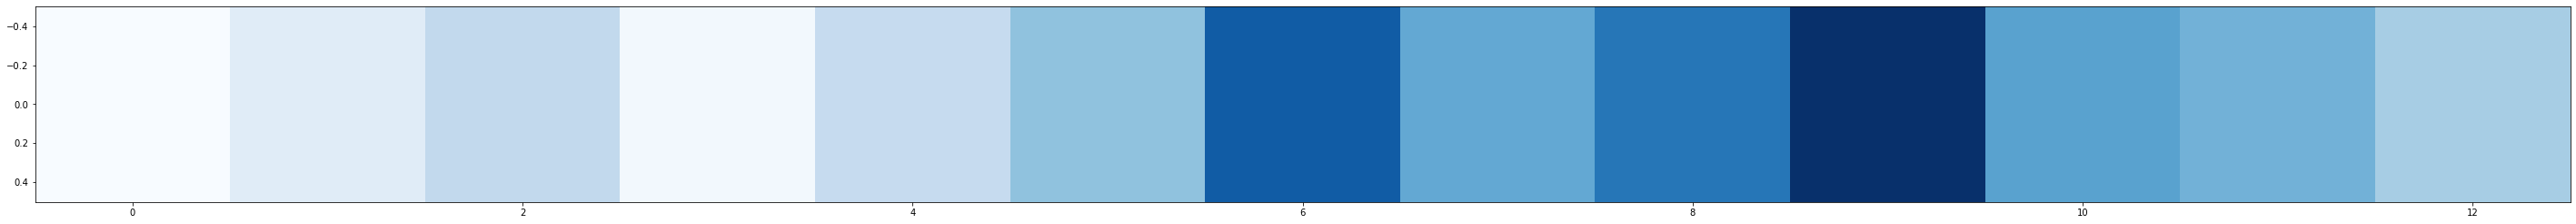

In [57]:
index=750
fc3_numpy=0
for i in pre_out[index][1][2][0]:
    fc3_numpy+=i.detach().numpy()

cmap = plt.cm.get_cmap('Blues', 200)

plt.figure()
plt.figure(figsize=(50,10))
ax = plt.gca()

#Table=plt.imshow(pre_out[0][1][4].detach().numpy(), cmap=cmap)
Table=plt.imshow(fc3_numpy, cmap=cmap)
#print(compound[index], target[index])

<Figure size 432x288 with 0 Axes>

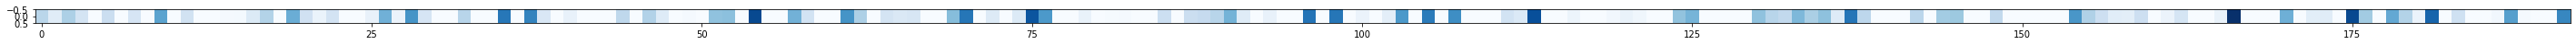

In [58]:
index=750
fc4_numpy=pre_out[index][1][5].detach().numpy()
plt.figure()
plt.figure(figsize=(50,10))
ax = plt.gca()
Table=plt.imshow(fc4_numpy, cmap=cmap)
#print(compound[index], target[index])

['Al1Cu2Mn1'] tensor([[1.]]) tensor([0.0508], grad_fn=<SelectBackward0>)


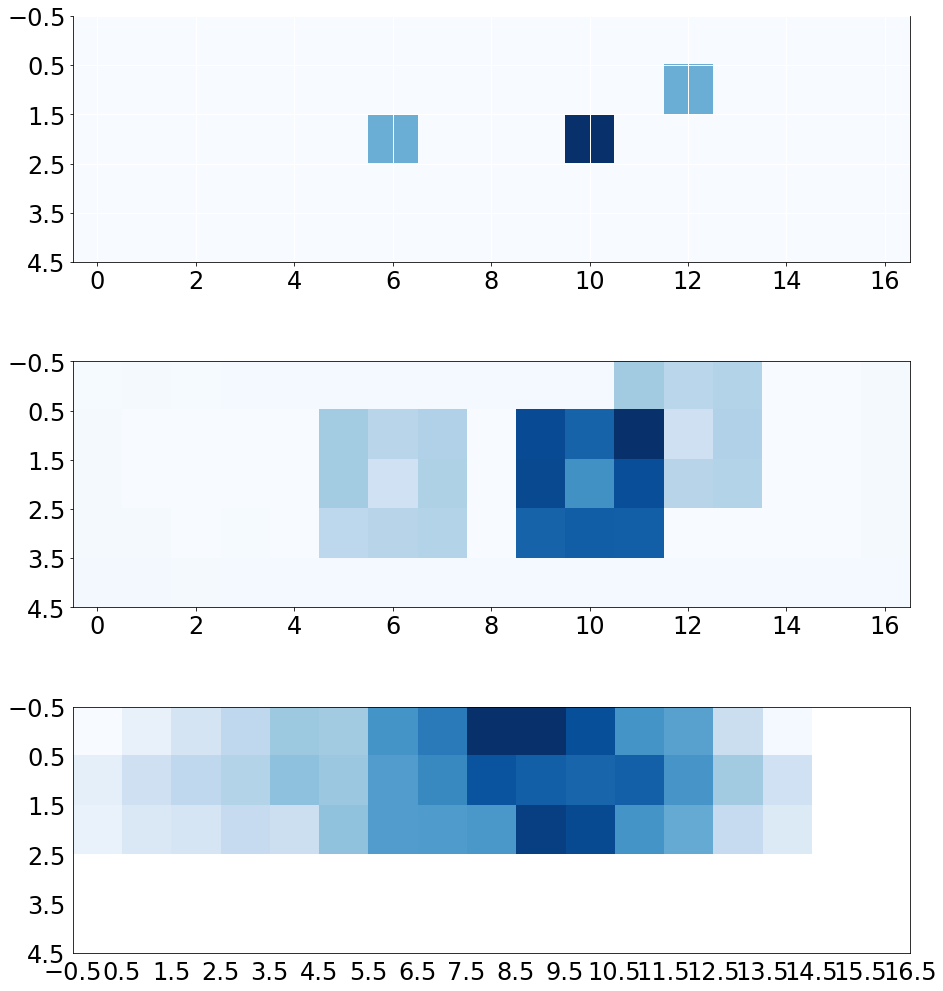

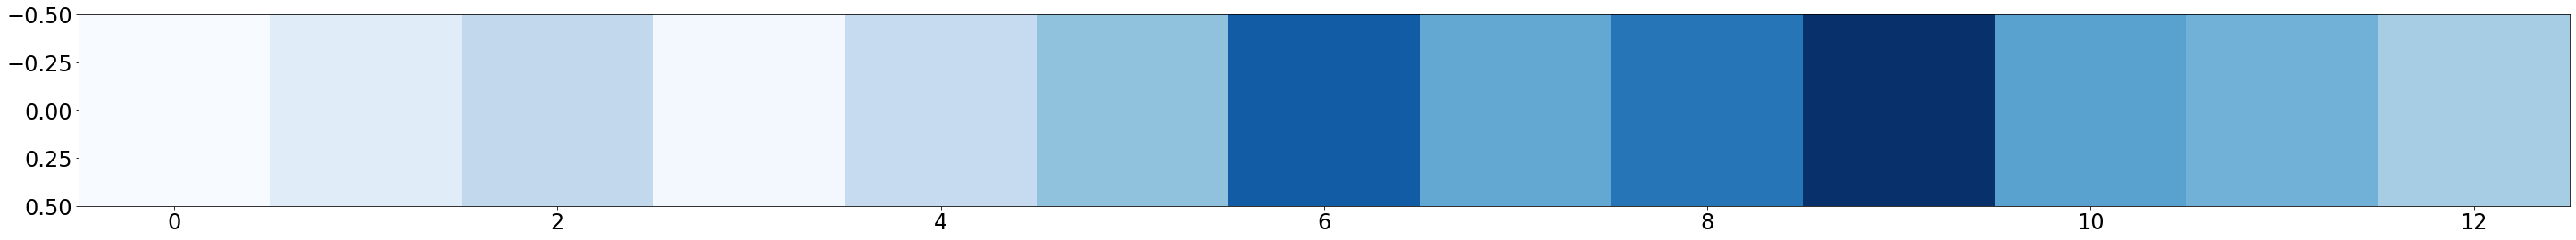

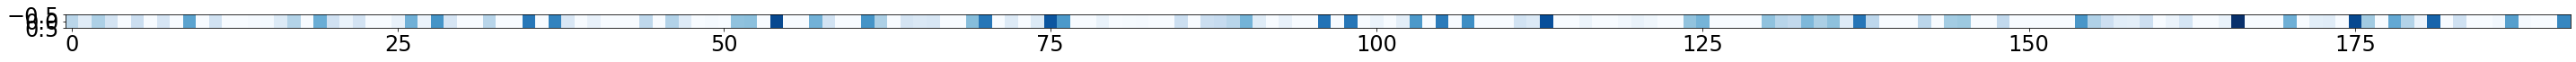

In [65]:
index=750
cmap = plt.cm.get_cmap('Blues', 200)
fig, axs = plt.subplots(3, 1,  figsize=(15,18), sharey=True)
#plt.figure(figsize=(15,18))
#axs[0] = plt.gca()

fc1_numpy=0
for i in pre_out[index][1][0][0]:
    fc1_numpy+=i.detach().numpy()
fc2_numpy=0
for i in pre_out[index][1][1][0]:
    fc2_numpy+=i.detach().numpy()
    
Table0=axs[0].imshow(input_var[index][0][0].detach().numpy(), cmap=cmap, vmin=0)
Table1=axs[1] .imshow(fc1_numpy, cmap=cmap)
Table2=axs[2] .imshow(fc2_numpy, cmap=cmap)
my_x_ticks = np.arange(-0.5, 17.5, 1) # 坐标范围，颜色，字体
my_y_ticks = np.arange(-0.5, 5.5, 1) # 坐标范围，颜色，字体
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

divider = make_axes_locatable(ax) # colorbar 位置，距离主图位置，宽度
cax = divider.append_axes("right", size="3%", pad=0.1) # colorbar 位置，距离主图位置，宽度
cb = plt.colorbar(Table, cax=cax)
cb.set_label('Flat Bnad Prob.') # colorbar 标注
plt.rcParams['font.size'] = 24 # colorbar 字体大小
axs[0].grid(color = 'w',linestyle='-',linewidth = 1) # 网格线
axs[0].spines['top'].set_color('None') #边框线消失
axs[0].spines['right'].set_color('black') #边框线消失
axs[0].spines['left'].set_color('black') #边框线消失
axs[0].spines['bottom'].set_color('black')  #边框线消失
plt.tick_params(width=0)  #坐标刻度消失

fc3_numpy=0
for i in pre_out[index][1][2][0]:
    fc3_numpy+=i.detach().numpy()
plt.figure(figsize=(50,10))
ax = plt.gca()
Table4=plt.imshow(fc3_numpy, cmap=cmap)

fc4_numpy=pre_out[index][1][5].detach().numpy()
plt.figure(figsize=(50,10))
Table5=plt.imshow(fc4_numpy, cmap=cmap)
print(compound[index], target_var[index], pre_out[index][0][0])

In [118]:
input_1=input_var[index][0][0]

In [120]:
input_1+1

tensor([[0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.9000, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 2.4000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 2.4000, 0.9000, 0.9000,
         0.9000, 3.8000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.9000, 0.9000, 1.0000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000]])

['Al1Cu2Mn1']


<Figure size 432x288 with 0 Axes>

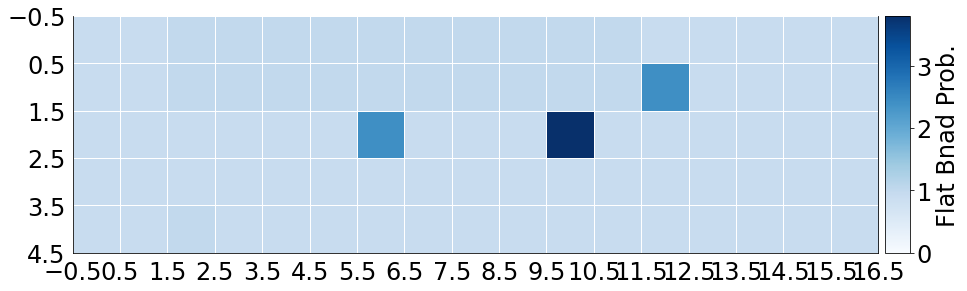

In [121]:
index=750
cmap = plt.cm.get_cmap('Blues', 200)
plt.figure()
plt.figure(figsize=(15,18))
ax = plt.gca()
    
Table=plt.imshow(input_var[index][0][0].detach().numpy()+1, cmap=cmap, vmin=0)
my_x_ticks = np.arange(-0.5, 17.5, 1) # 坐标范围，颜色，字体
my_y_ticks = np.arange(-0.5, 5.5, 1) # 坐标范围，颜色，字体
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.tick_params(width=0)  #坐标刻度消失
ax.spines['top'].set_color('None') #边框线消失
ax.spines['right'].set_color('black') #边框线消失
ax.spines['left'].set_color('black') #边框线消失
ax.spines['bottom'].set_color('black')  #边框线消失
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax) # colorbar 位置，距离主图位置，宽度
cax = divider.append_axes("right", size="3%", pad=0.1) # colorbar 位置，距离主图位置，宽度
cb = plt.colorbar(Table, cax=cax)
cb.set_label('Flat Bnad Prob.') # colorbar 标注
plt.rcParams['font.size'] = 24 # colorbar 字体大小
ax.grid(color = 'w',linestyle='-',linewidth = 1) # 网格线
plt.savefig('input.png', dpi=300)
print(compound[index])

['Al1Cu2Mn1']


<Figure size 432x288 with 0 Axes>

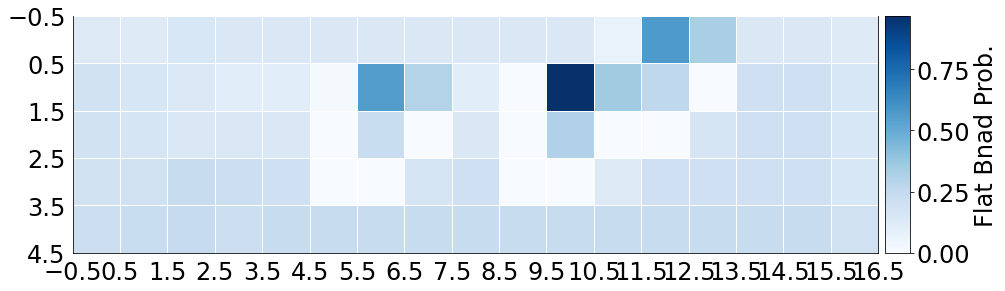

In [88]:
index=750
fc1_numpy=0
for i in pre_out[index][1][0][0]:
    fc1_numpy+=i.detach().numpy()
    
cmap = plt.cm.get_cmap('Blues', 200)

plt.figure()
plt.figure(figsize=(15,18))
ax = plt.gca()

Table=plt.imshow(pre_out[index][1][0][0][56].detach().numpy(), cmap=cmap)
#Table=plt.imshow(fc1_numpy, cmap=cmap)
my_x_ticks = np.arange(-0.5, 17.5, 1) # 坐标范围，颜色，字体
my_y_ticks = np.arange(-0.5, 5.5, 1) # 坐标范围，颜色，字体
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.tick_params(width=0)  #坐标刻度消失
ax.spines['top'].set_color('None') #边框线消失
ax.spines['right'].set_color('black') #边框线消失
ax.spines['left'].set_color('black') #边框线消失
ax.spines['bottom'].set_color('black')  #边框线消失
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax) # colorbar 位置，距离主图位置，宽度
cax = divider.append_axes("right", size="3%", pad=0.1) # colorbar 位置，距离主图位置，宽度
cb = plt.colorbar(Table, cax=cax)
cb.set_label('Flat Bnad Prob.') # colorbar 标注
plt.rcParams['font.size'] = 24 # colorbar 字体大小
ax.grid(color = 'w',linestyle='-',linewidth = 1) # 网格线
plt.savefig('out1_56.png', dpi=300)
print(compound[index])

['Al1Cu2Mn1']


<Figure size 432x288 with 0 Axes>

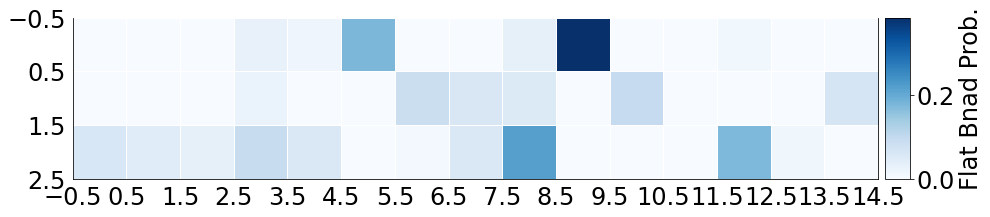

In [98]:
index=750
fc2_numpy=0
for i in pre_out[index][1][1][0]:
    fc2_numpy+=i.detach().numpy()

cmap = plt.cm.get_cmap('Blues', 200)

plt.figure()
plt.figure(figsize=(15,16))
ax = plt.gca()

#Table=plt.imshow(fc2_numpy, cmap=cmap)
Table=plt.imshow(pre_out[index][1][1][0][95].detach().numpy(), cmap=cmap)
my_x_ticks = np.arange(-0.5, 15.5, 1) # 坐标范围，颜色，字体
my_y_ticks = np.arange(-0.5, 3.5, 1) # 坐标范围，颜色，字体
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.tick_params(width=0)  #坐标刻度消失
ax.spines['top'].set_color('None') #边框线消失
ax.spines['right'].set_color('black') #边框线消失
ax.spines['left'].set_color('black') #边框线消失
ax.spines['bottom'].set_color('black')  #边框线消失
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax) # colorbar 位置，距离主图位置，宽度
cax = divider.append_axes("right", size="3%", pad=0.1) # colorbar 位置，距离主图位置，宽度
cb = plt.colorbar(Table, cax=cax)
cb.set_label('Flat Bnad Prob.') # colorbar 标注
plt.rcParams['font.size'] = 24 # colorbar 字体大小
ax.grid(color = 'w',linestyle='-',linewidth = 1) # 网格线
plt.savefig('out2_95.png', dpi=300)
print(compound[index])

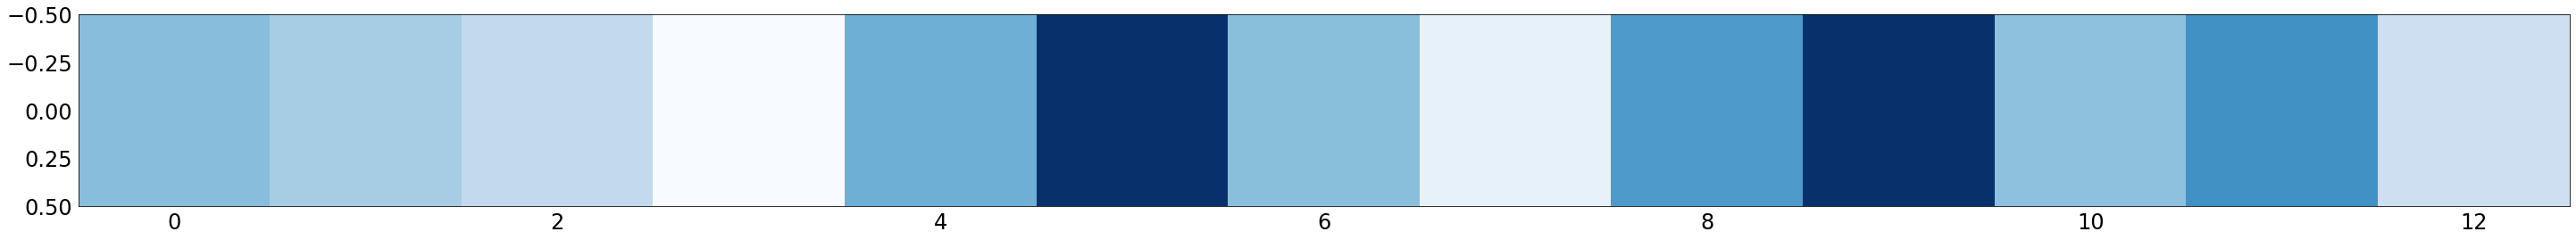

In [111]:
fc3_numpy=750
for i in pre_out[index][1][2][0]:
    fc3_numpy+=i.detach().numpy()
plt.figure(figsize=(50,10))
ax = plt.gca()
#Table4=plt.imshow(fc3_numpy, cmap=cmap)
Table4=plt.imshow(pre_out[index][1][2][0][95].detach().numpy(), cmap=cmap)
plt.tick_params(width=0)  #坐标刻度消失
plt.savefig('out3_95.png', dpi=300)
# ax.spines['top'].set_color('blck') #边框线消失
# ax.spines['right'].set_color('blck') #边框线消失
# ax.spines['left'].set_color('blck') #边框线消失
# ax.spines['bottom'].set_color('blck')  #边框线消失

['Al1Cu2Mn1'] tensor([[1.]]) tensor([0.0508], grad_fn=<SelectBackward0>)


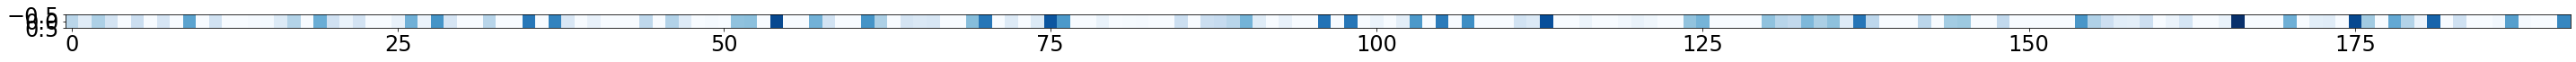

In [114]:
fc4_numpy=pre_out[index][1][5].detach().numpy()
plt.figure(figsize=(50,20))
Table5=plt.imshow(fc4_numpy, cmap=cmap)
print(compound[index], target_var[index], pre_out[index][0][0])
plt.savefig('out4.png', dpi=300)

In [190]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.decomposition import PCA

In [17]:
pca_breast = PCA(n_components=2)

In [14]:
pre_out015_dic

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
Ti1Co2Ga1,0.000000,2.589474,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Al1Ni2Hf1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.469513,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.714244,0.0
Mn1Co2Sn1,0.785023,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.410463,0.0,...,0.0,0.000000,0.0,5.778038,0.0,0.000000,0.0,0.0,0.000000,0.0
Fe2Co1Ga1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.923627,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Li1As1Pd2,0.000000,0.000000,0.0,0.0,0.968544,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ca2Cu1Rh1,0.112906,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,1.715689,0.0,0.0,0.000000,0.0
Ni1Cu2Sb1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Na1Cd1Hg2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Co2Zn1Hf1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.231949,0.000000,0.0,...,0.0,1.274808,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [19]:
pre_out015_PCA = pca_breast.fit(pre_out015_dic)

In [20]:
pre_out015_PCA = pca_breast.fit_transform(pre_out015_dic)

In [21]:
pre_out015_PCA

array([[-0.91346943,  0.04019212],
       [-0.11768372, -1.0902989 ],
       [-1.9885149 ,  1.5692406 ],
       ...,
       [ 0.99175084,  0.12220521],
       [ 3.0768518 ,  1.870416  ],
       [ 0.5033574 ,  0.00927188]], dtype=float32)

In [22]:
pca_breast.n_components_

2

In [23]:
pca_breast.explained_variance_ratio_

array([0.10199251, 0.07466119], dtype=float32)

In [24]:
pca_breast.explained_variance_

array([2.1959488, 1.607492 ], dtype=float32)

In [25]:
pre_out015_PCA

array([[-0.91346943,  0.04019212],
       [-0.11768372, -1.0902989 ],
       [-1.9885149 ,  1.5692406 ],
       ...,
       [ 0.99175084,  0.12220521],
       [ 3.0768518 ,  1.870416  ],
       [ 0.5033574 ,  0.00927188]], dtype=float32)

In [26]:
pre_out015_PCA_df = pd.DataFrame(data = pre_out015_PCA, columns = ['PCA1', 'PCA2'])
pre_out015_PCA_cor=pre_out015_PCA_df.corr()

In [27]:
pre_out015_PCA_df['index']= pre_out015_dic.index

In [104]:
import re
pre_out015_PCA_df['eleX']=''
pre_out015_PCA_df['eleYZ']=''
for index, rows in pre_out015_PCA_df.iterrows():
    compound=pre_out015_PCA_df['index'][index]
    res=re.split('(\d+)', compound)
    eleYZ=[]
    for i in range(len(res)):
        if res[i] =='2':
            pre_out015_PCA_df['eleX'][index]=res[i-1]
        elif res[i] =='1':
            eleYZ.append(res[i-1])
    pre_out015_PCA_df['eleYZ'][index]=eleYZ

C:\Users\ying2\AppData\Local\Temp/ipykernel_15252/491232553.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_out015_PCA_df['eleX'][index]=res[i-1]
C:\Users\ying2\AppData\Local\Temp/ipykernel_15252/491232553.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_out015_PCA_df['eleYZ'][index]=eleYZ


In [116]:
PCA_df=pre_out015_PCA_df[['PCA1','PCA2']]
PCA_df_cor=PCA_df.corr(method='spearman')

<Figure size 432x288 with 0 Axes>

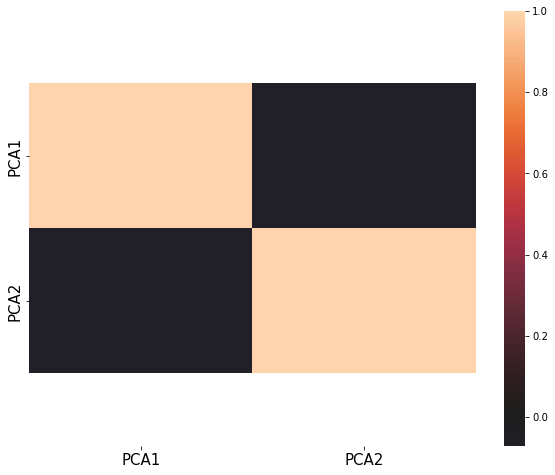

In [117]:
#PCA_df_cor=PCA_df.corr(method='spearman')
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax=sns.heatmap(PCA_df_cor, center=0, fmt='d') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [120]:
pre_out015_PCA_df_200=pre_out015_PCA_df.sample(200)

In [99]:
eleX_list=[]
for index, rows in pre_out015_PCA_df.iterrows():
    eleX_list.append(pre_out015_PCA_df['eleX'][index])
eleX_set=set(eleX_list)

In [102]:
for ele in eleX_set:
    #eleX_list.count(ele)
    print(ele, eleX_list.count(ele))

Os 17
Ir 39
Ta 36
As 2
Fe 43
Br 1
Bi 1
Tc 42
W 5
Pd 67
Al 23
Tl 17
Cs 1
Cl 2
Au 34
Si 5
In 8
Ga 17
Sb 1
Zn 17
Be 29
Mo 1
Rb 4
Ti 65
Ca 47
Sn 1
B 1
Mn 29
Pb 4
P 6
V 22
Re 12
Cd 14
S 1
Pt 18
Na 12
Mg 17
Hf 48
Hg 18
Ru 82
Ag 19
Rh 88
Li 36
Co 63
Cu 31
Sr 34
Ni 55
Zr 19
Nb 11
Se 3
Te 3
K 8
Ba 21


In [76]:
eleX_dict={}
for ele in eleX_set:
    eleX_dict[ele]=[]

In [78]:
eleX_PCA1={}
for index, rows in pre_out015_PCA_df.iterrows():
    eleX=pre_out015_PCA_df['eleX'][index]
    eleX_list=eleX_dict[eleX]
    eleX_list.append(pre_out015_PCA_df['PCA1'][index])
    eleX_PCA1[eleX]=eleX_list

In [80]:
eleX_PCA1_avg={}
for keys in eleX_PCA1.keys():
    eleX_list=eleX_PCA1[keys]
    eleX_avg=sum(eleX_list)/float(len(eleX_list))
    eleX_PCA1_avg[keys]=eleX_avg

In [96]:
eleX_PCA1['Ti']

[-1.9885149,
 -2.0040255,
 -3.2145298,
 -2.2957795,
 -2.5325885,
 -3.0187201,
 -1.1477631,
 -2.372771,
 -1.780539,
 -2.1479168,
 -0.51392764,
 -3.2282078,
 -2.5517812,
 -2.2558618,
 -2.5274057,
 -4.00603,
 -0.7017342,
 -0.105766185,
 -0.5762143,
 0.03720863,
 -3.6565673,
 -3.649546,
 -3.4112945,
 -1.0803722,
 -4.0623617,
 -1.0537595,
 -2.756635,
 -0.90621275,
 -2.9839935,
 -0.1791332,
 -1.4406574,
 -3.051225,
 -0.4060749,
 -2.7513328,
 -0.12984832,
 -0.797002,
 -1.0978416,
 -5.129527,
 -2.882914,
 -2.8142426,
 -0.39271232,
 -1.3149526,
 -0.4402201,
 -0.6942126,
 -4.0871572,
 -0.8060555,
 -2.101453,
 -2.378851,
 -2.0395813,
 -0.1796183,
 -2.2022817,
 0.005169469,
 -1.1534773,
 -0.08377336,
 -3.1458116,
 -0.10971442,
 -1.7767504,
 -2.70601,
 -2.6555822,
 -2.4670184,
 -2.6222987,
 -1.9061148,
 -1.169233,
 -1.9435173,
 -3.374141]

In [81]:
num_ele={1:'H', 3:'Li', 4:'Be', 5:'B', 6:'C', 7:'N',8:'O', 9:'F', 11:'Na', 
 12:'Mg', 13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl', 19:'K', 
 20:'Ca', 21:'Sc', 22:'Ti', 23:'V', 24:'Cr', 25:'Mn', 26:'Fe', 
 27:'Co', 28:'Ni', 29:'Cu', 30:'Zn', 31:'Ga', 32:'Ge', 33:'As', 
 34:'Se', 35:'Br', 37:'Rb', 38:'Sr', 39:'Y', 40:'Zr', 41:'Nb', 
 42:'Mo', 43: 'Tc', 44:'Ru', 45:'Rh', 46:'Pd', 47:'Ag', 48: 'Cd', 49:'In', 50:'Sn', 51:'Sb', 52:'Te', 55:'Cs', 
 56:'Ba', 57:'La', 72:'Hf', 73:'Ta', 74:'W', 75:'Re', 76:'Os', 77:'Ir', 78:'Pt', 79:'Au', 80:'Hg', 81:'Tl', 82:'Pb', 83:'Bi'}

In [82]:
X=[]
y=[]
for keys in eleX_PCA1_avg.keys():
    if len(get_keys(num_ele, keys))==0:
        print(keys)
    X.append(get_keys(num_ele, keys)[0])
    y.append(eleX_PCA1_avg[keys])

In [83]:
Xy = [(xi, yi) for xi, yi in zip(X, y) ]
sorted_Xy = sorted(Xy)
sorted_X = [xi for xi,_ in sorted_Xy]
sorted_y = [yi for _,yi in sorted_Xy]

In [84]:
eleX_list=[]
for elenum in sorted_X:
    eleX_list.append(num_ele[elenum])

In [85]:
pre_out015_PCA_df['elenum']=''
for index, rows in pre_out015_PCA_df.iterrows():
    eleX=pre_out015_PCA_df['eleX'][index]
    ele_num=get_keys(num_ele, eleX)[0]
    pre_out015_PCA_df['elenum'][index]=ele_num

C:\Users\ying2\AppData\Local\Temp/ipykernel_15252/532632898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_out015_PCA_df['elenum'][index]=ele_num


In [86]:
pre_out015_PCA_df_sort=pre_out015_PCA_df.sort_values(by=['elenum'])

In [87]:
boxs=[]
names = locals()
for ele in eleX_list:
    box_ele=[]
    for index in pre_out015_PCA_df_sort.index:
        df_ele=pre_out015_PCA_df_sort['eleX'][index]
        if df_ele==ele:
            box_ele.append(pre_out015_PCA_df_sort['PCA1'][index])
    exec('box_{}={}'.format(ele, box_ele))
    boxs.append(names.get('box_' + str(ele)))

In [88]:
boxs

[[2.9346075,
  2.0938926,
  2.413004,
  1.6663132,
  4.452866,
  0.79787415,
  1.5958455,
  3.4973056,
  1.0588588,
  3.7284832,
  3.8334706,
  0.64011914,
  2.0133202,
  1.6786853,
  2.6198244,
  2.292489,
  1.7208031,
  3.1949477,
  0.45805266,
  1.5152695,
  0.14627293,
  2.3439596,
  2.3913603,
  2.361258,
  1.6840665,
  6.388759,
  1.0760584,
  1.246456,
  6.7579327,
  1.0516143,
  5.1222444,
  3.2990289,
  4.1629415,
  2.2830222,
  3.0428526,
  4.081121],
 [3.149334,
  -0.14947085,
  -0.030651642,
  0.05541208,
  0.95610154,
  -0.012075078,
  0.010469288,
  -0.026340181,
  0.12702052,
  -0.06672844,
  0.0042992528,
  0.0006679846,
  -0.053265147,
  0.25941712,
  -0.060698185,
  0.026095834,
  -0.007931273,
  -0.13374107,
  -0.038016453,
  2.046663,
  0.043450143,
  0.013199949,
  -0.018373875,
  -0.112564735,
  0.065198876,
  0.14701776,
  0.40513673,
  -0.0059285853,
  -0.0036761903],
 [0.122617595],
 [2.5192523,
  0.22040847,
  0.9913916,
  0.33640307,
  0.14612551,
  4.0649486

C:\Users\ying2\AppData\Local\Temp/ipykernel_15252/737035222.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('pre_out015_PCA1', dip=800)


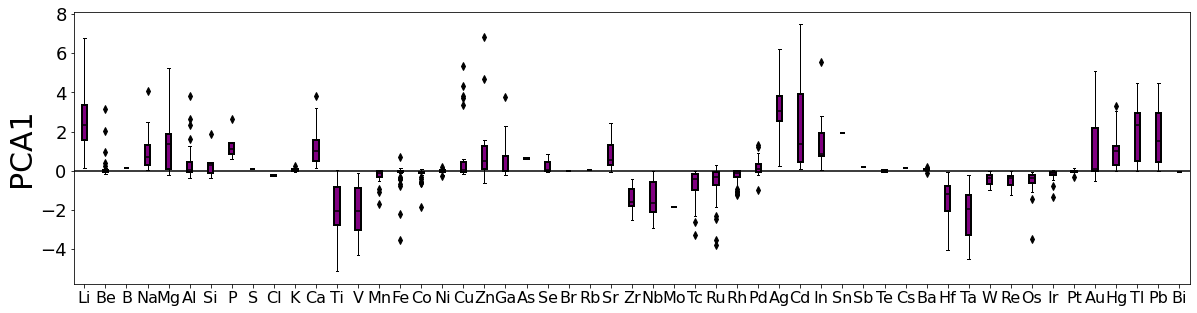

In [90]:
import seaborn as sns
plt.figure(figsize=(20,5))
# plt.xlim(0.5, 44.5)
plt.ylabel('PCA1',fontsize=30)
plt.xticks(fontsize=16, color="black")
plt.yticks(fontsize=18, color="black")

green_diamond = dict(markerfacecolor='black', markersize=5, marker='d')
medianprops = dict(linestyle='-.', linewidth=1.5, color='black')
boxprops = dict(linestyle='-', linewidth=2, color='black', facecolor='purple')

#plt.plot(pre_out015_PCA_df_sort['eleX'], pre_out015_PCA_df_sort['PCA2'], '-o',linewidth=0)

ax=plt.boxplot(boxs, labels=eleX_list, patch_artist = True, boxprops=boxprops, 
               flierprops=green_diamond, whis=2, widths=0.25, medianprops=medianprops)  

# plt.axhline(y=-1.5, color='b',linestyle='--')
# plt.axhline(y=1.5, color='b',linestyle='--')
plt.axhline(y=0, color='k',linestyle='-')
plt.savefig('pre_out015_PCA1', dip=800)
plt.show()

<Figure size 432x288 with 0 Axes>

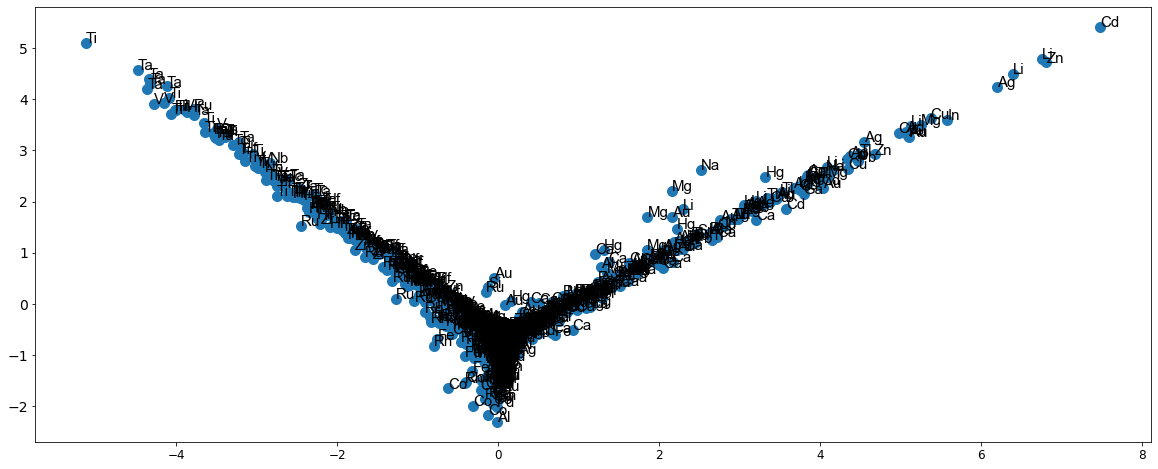

In [118]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(20,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
#plt.xlabel('Dim2',fontsize=38)
#plt.ylabel('Covalent Radius',fontsize=38)
plt.plot(pre_out015_PCA_df['PCA1'], pre_out015_PCA_df['PCA2'], 'o', markersize=10)
for index, row in pre_out015_PCA_df.iterrows():
    plt.annotate(pre_out015_PCA_df['eleX'][index], xy = (pre_out015_PCA_df['PCA1'][index], pre_out015_PCA_df['PCA2'][index]), 
                 xytext = (pre_out015_PCA_df['PCA1'][index], pre_out015_PCA_df['PCA2'][index]), 
                 fontsize=15, fontproperties='Arial') 
plt.savefig('PCA2_covalentradius')

In [81]:
pre_out015_PCA_df.loc[1:200]

,PCA1,PCA2,index
1,-0.650389,-0.113305,Co1Hf2Os1
2,0.035307,-1.017652,Al1Mn1Ir2
3,1.527317,0.600452,Sr2Cd1In1
4,-0.009205,-1.008213,Mg1Sn1Ir2
5,0.818890,-0.080140,Li2Mg1Tl1
...,...,...,...
196,0.102268,-0.741335,Sr1Ba1Hg2
197,0.090243,-0.840240,Mn1As1Pd2
198,-0.942464,0.277804,Co2Zr1Hf1
199,-0.700556,-0.203869,Pd1Hf2Re1


In [13]:
from sklearn.manifold import TSNE

In [15]:
pre_out015_dic

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
Ti1Co2Ga1,0.000000,2.589474,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Al1Ni2Hf1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.469513,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.714244,0.0
Mn1Co2Sn1,0.785023,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.410463,0.0,...,0.0,0.000000,0.0,5.778038,0.0,0.000000,0.0,0.0,0.000000,0.0
Fe2Co1Ga1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.923627,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Li1As1Pd2,0.000000,0.000000,0.0,0.0,0.968544,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ca2Cu1Rh1,0.112906,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,1.715689,0.0,0.0,0.000000,0.0
Ni1Cu2Sb1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Na1Cd1Hg2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Co2Zn1Hf1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.231949,0.000000,0.0,...,0.0,1.274808,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [26]:
pre_out015_dic.index.values

array(['Ti1Co2Ga1', 'Al1Ni2Hf1', 'Mn1Co2Sn1', ..., 'Na1Cd1Hg2',
       'Co2Zn1Hf1', 'Ga2Se1W1'], dtype=object)

In [16]:
time_start = time.time()
RS = 123

fashion_tsne = TSNE(random_state=RS).fit_transform(pre_out015_dic)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 7.394404649734497 seconds


In [17]:
M_bond_tsne_df = pd.DataFrame(data = fashion_tsne, columns = ['tsen1', 'tsen2'])

In [27]:
M_bond_tsne_df['compound']= pre_out015_dic.index.values

In [34]:
M_bond_tsne_df

,tsen1,tsen2,compound,eleX,eleYZ
0,5.368178,-34.866825,Ti1Co2Ga1,,
1,-8.472364,-32.145065,Al1Ni2Hf1,,
2,9.077885,-40.430527,Mn1Co2Sn1,,
3,-13.052209,-23.004484,Fe2Co1Ga1,,
4,-14.406366,-5.548920,Li1As1Pd2,,
...,...,...,...,...,...
1195,-5.389778,9.328820,Ca2Cu1Rh1,,
1196,-26.202002,-5.957977,Ni1Cu2Sb1,,
1197,-34.539536,21.148945,Na1Cd1Hg2,,
1198,6.005105,-18.150045,Co2Zn1Hf1,,


In [35]:
import re
M_bond_tsne_df['eleX']=''
M_bond_tsne_df['eleYZ']=''
for index, rows in M_bond_tsne_df.iterrows():
    compound=M_bond_tsne_df['compound'][index]
    res=re.split('(\d+)', compound)
    eleYZ=[]
    for i in range(len(res)):
        if res[i] =='2':
            M_bond_tsne_df['eleX'][index]=res[i-1]
        elif res[i] =='1':
            eleYZ.append(res[i-1])
    M_bond_tsne_df['eleYZ'][index]=eleYZ

C:\Users\ying2\AppData\Local\Temp/ipykernel_11920/4092131785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M_bond_tsne_df['eleX'][index]=res[i-1]
C:\Users\ying2\AppData\Local\Temp/ipykernel_11920/4092131785.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M_bond_tsne_df['eleYZ'][index]=eleYZ


In [19]:
def fashion_scatter(x, y, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))+1
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    area = np.pi * 3**2
    cm=plt.cm.get_cmap('RdYlBu_r')
    sc = ax.scatter(x, y, s=area, c=palette[colors.astype(np.int)], cmap=cm)
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
#     plt.xlabel('tsen1',fontsize=20)
#     plt.ylabel('tsen2',fontsize=20)
#     plt.title("Principal Component Analysis",fontsize=20)
    
    ax.axis('off')
    ax.axis('tight')
    #plt.savefig('C:\\Users\\zhang\\workshop-2017\\cgcnn-master\\my_cgcnn\\Li_battery_voltage\\predict_analysis\\t-SNE_neighbors')

    #plt.colorbar()

In [ ]:
fashion_scatter(M_bond_tsne_df['tsen1'], M_bond_tsne_df['tsen2'])

<Figure size 432x288 with 0 Axes>

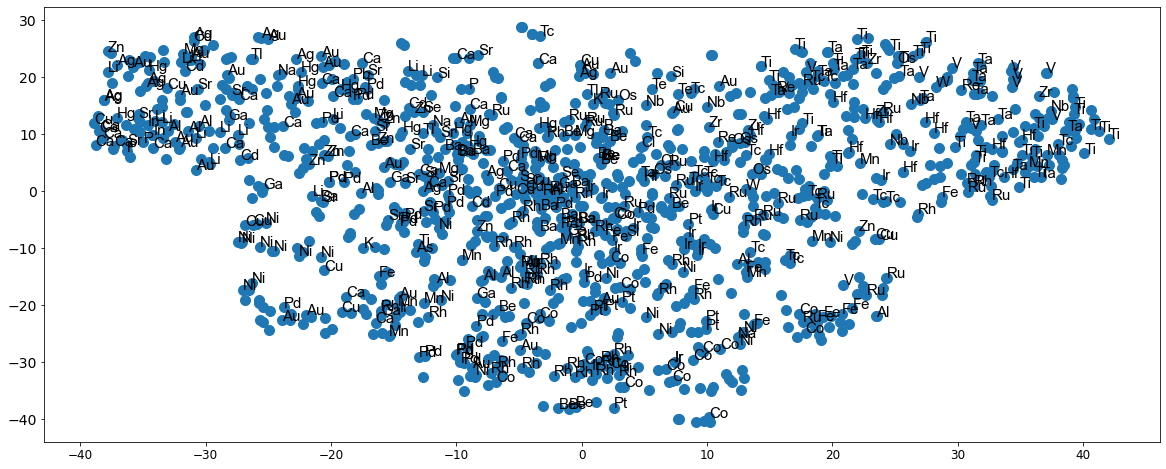

In [37]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(20,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
#plt.xlabel('Dim2',fontsize=38)
#plt.ylabel('Covalent Radius',fontsize=38)
plt.plot(M_bond_tsne_df['tsen1'], M_bond_tsne_df['tsen2'], 'o', markersize=10)
for index, row in M_bond_tsne_df.sample(500).iterrows():
    plt.annotate(M_bond_tsne_df['eleX'][index], xy = (M_bond_tsne_df['tsen1'][index], M_bond_tsne_df['tsen2'][index]), 
                 xytext = (M_bond_tsne_df['tsen1'][index], M_bond_tsne_df['tsen2'][index]), 
                 fontsize=15, fontproperties='Arial') 